# Data Extraction, Visualization, Exploration and Preparation

In [1]:
import pandas as pd
import datetime as dtime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

with open("../../data/crypto-markets.csv") as f:
    df = pd.read_csv(f)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942297 entries, 0 to 942296
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   slug         942297 non-null  object 
 1   symbol       942297 non-null  object 
 2   name         942297 non-null  object 
 3   date         942297 non-null  object 
 4   ranknow      942297 non-null  int64  
 5   open         942297 non-null  float64
 6   high         942297 non-null  float64
 7   low          942297 non-null  float64
 8   close        942297 non-null  float64
 9   volume       942297 non-null  float64
 10  market       942297 non-null  float64
 11  close_ratio  942297 non-null  float64
 12  spread       942297 non-null  float64
dtypes: float64(8), int64(1), object(4)
memory usage: 93.5+ MB


In [13]:
# see how many different coins we have
print(f'There is { df["slug"].unique().shape[0]} different currencies in this dataset.')

There is 2071 different currencies in this dataset.


In [33]:
df.head()

,slug,symbol,name,date,ranknow,open,high,low,close,volume,market,close_ratio,spread
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0.0,1.49e+09,0.54,3.88
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0.0,1.60e+09,0.78,13.49
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0.0,1.54e+09,0.38,12.88
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0.0,1.30e+09,0.29,32.17
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0.0,1.17e+09,0.39,33.32


In [34]:
# convert date from str format to datetime timestamp format
df['date']= pd.to_datetime(df['date'])


# separate bitcoin data
df_btc = df.groupby('symbol').get_group('BTC')


# drop unwanted columns
df_btc = df_btc.drop(columns=['market', 'close_ratio', 'spread'])

# add

df_btc

,slug,symbol,name,date,ranknow,open,high,low,close,volume
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0.00e+00
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0.00e+00
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0.00e+00
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0.00e+00
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0.00e+00
...,...,...,...,...,...,...,...,...,...,...
2037,bitcoin,BTC,Bitcoin,2018-11-25,1,3880.78,4120.87,3585.06,4009.97,6.83e+09
2038,bitcoin,BTC,Bitcoin,2018-11-26,1,4015.07,4107.14,3643.92,3779.13,6.48e+09
2039,bitcoin,BTC,Bitcoin,2018-11-27,1,3765.95,3862.96,3661.01,3820.72,6.00e+09
2040,bitcoin,BTC,Bitcoin,2018-11-28,1,3822.47,4385.90,3822.47,4257.42,7.28e+09


---
Just to have a better understanding of the data:


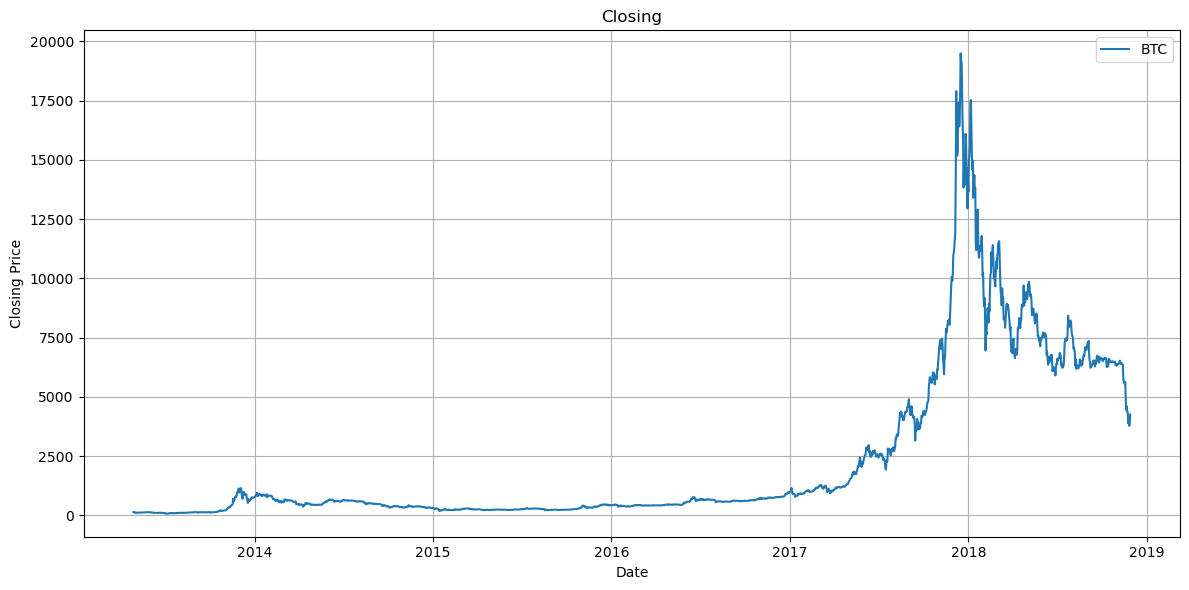

In [80]:
# add changable start and end date for adjustable time window
start_date = "2013-04-28"
end_date = "2018-11-29"
df_btc_date_picked = df_btc[(df_btc['date'] >= start_date) & (df_btc['date'] <= end_date)]
plt.figure(figsize=(12,6))
plt.plot(df_btc_date_picked['date'], df_btc_date_picked['close'], label= 'BTC')
plt.title('Closing')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

---
The aim is to predict the tomorrow's closing price. as the selected features are considered inputs for the prediction of the next day's price, there should be a lag between them and the target variable. one way is to move all the features one day forward, to align them with tomorrow's closing price, or implement a better approach of moving closing price one day bacwards.

In [77]:
# shift closing price, the target, backwards to create the lagged effect
df_btc['close_lag-1']= df_btc['close'].shift(-1)

# drop nan value created by this tranformation (here is only one row, the last row)
df_btc = df_btc.dropna()

df_btc



,slug,symbol,name,date,ranknow,open,high,low,close,volume,close_lag-1
0,bitcoin,BTC,Bitcoin,2013-04-28,1,135.30,135.98,132.10,134.21,0.00e+00,144.54
1,bitcoin,BTC,Bitcoin,2013-04-29,1,134.44,147.49,134.00,144.54,0.00e+00,139.00
2,bitcoin,BTC,Bitcoin,2013-04-30,1,144.00,146.93,134.05,139.00,0.00e+00,116.99
3,bitcoin,BTC,Bitcoin,2013-05-01,1,139.00,139.89,107.72,116.99,0.00e+00,105.21
4,bitcoin,BTC,Bitcoin,2013-05-02,1,116.38,125.60,92.28,105.21,0.00e+00,97.75
...,...,...,...,...,...,...,...,...,...,...,...
2036,bitcoin,BTC,Bitcoin,2018-11-24,1,4347.69,4413.09,3795.16,3880.76,4.68e+09,4009.97
2037,bitcoin,BTC,Bitcoin,2018-11-25,1,3880.78,4120.87,3585.06,4009.97,6.83e+09,3779.13
2038,bitcoin,BTC,Bitcoin,2018-11-26,1,4015.07,4107.14,3643.92,3779.13,6.48e+09,3820.72
2039,bitcoin,BTC,Bitcoin,2018-11-27,1,3765.95,3862.96,3661.01,3820.72,6.00e+09,4257.42


In [98]:
# pick features and target variable
y = df_btc['close_lag-1'].values
x = df_btc[['open', 'high', 'low', 'close']].values # TODO close seems like a good feature for it's future price, like a momentum. test model with and without it ?


# split the data, instead of randomly, pick the last year of data as testing set, and the rest as training set
max_date = max(df_btc['date'])

""" this was my first idea to split the data, using separation date and manually"""
# separation_date = max_date - dtime.timedelta(days=365) # let's say all years have 365 days, not that important here (should have used relativedelta from dateutil)

""" but lets use split function with shuffle turned off"""
test_size = 365 / (max_date - min(df_btc['date'])).days
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=test_size, shuffle=False)

print(f'x_test shape: {x_test.shape}')
print(f'x_train shape: {x_train.shape}')
print(f'y_test shape: {y_test.shape}')
print(f'y_train shape: {y_train.shape}')


x_test shape: (366, 4)
x_train shape: (1675, 4)
y_test shape: (366,)
y_train shape: (1675,)


In [103]:
# Data Normalization, lets do a simple MinMax
scaler = MinMaxScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)


y_train_reshaped = y_train.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)


y_train_scaled = scaler.fit_transform(y_train_reshaped)
y_test_scaled = scaler.transform(y_test_reshaped)

x_train_scaled

array([[0.007195  , 0.0063035 , 0.00716794, 0.00674672],
       [0.00710237, 0.00748477, 0.00737252, 0.00780622],
       [0.00813208, 0.00742729, 0.0073779 , 0.00723801],
       ...,
       [0.88033351, 0.8945554 , 0.87492772, 0.8946217 ],
       [0.93928623, 0.9696812 , 0.93785741, 0.94996882],
       [1.        , 1.        , 1.        , 1.        ]])

# Deep Learning

In [ ]:
# Structure of Model (layers, optimizer, loss, metrics)
# Define the model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Single output for the predicted closing price
])

In [ ]:
# Training the model

In [ ]:
# Validation

# Visualization and Sample Prediction for Future